In [1]:
from __future__ import print_function

import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b

Using TensorFlow backend.


In [2]:
# My first Step is to load both my content and style images

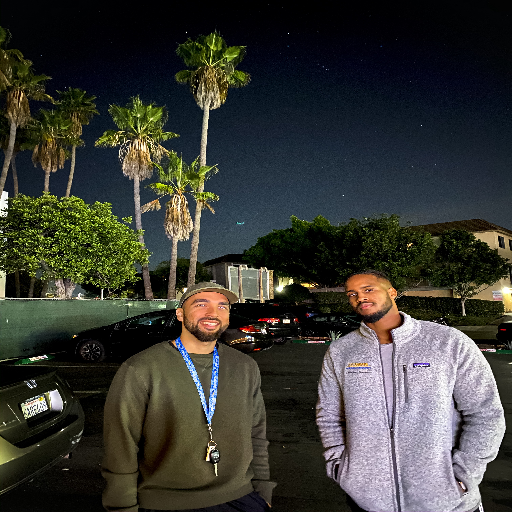

In [3]:
height = 512
width = 512

contentpath = 'friends.jpg'
contentImage = Image.open(contentpath)
contentImage = contentImage.resize((width, height))
contentImage

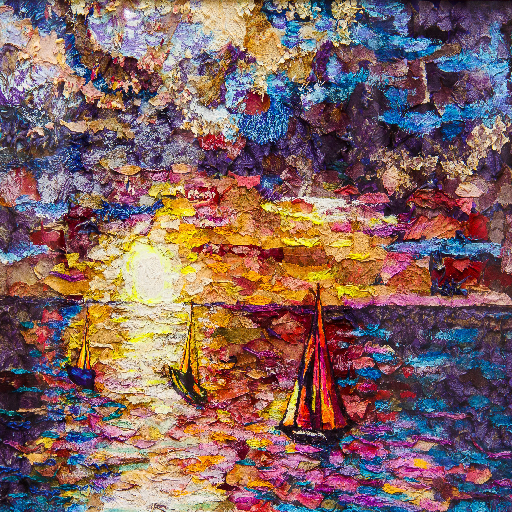

In [4]:
stylepath = 'artstyle.jpg'
styleImage = Image.open(stylepath)
styleImage = styleImage.resize((width, height))
styleImage

In [5]:
# Convert images into a form thats suitable for processing.
#so later we can concatenate both these images representation into a data strucuter

In [6]:
contentArray = np.asarray(contentImage, dtype='float32')
contentArray = np.expand_dims(contentArray, axis=0)
print(contentArray.shape)

styleArray = np.asarray(styleImage, dtype='float32')
styleArray = np.expand_dims(styleArray, axis=0)
print(styleArray.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


In [7]:
contentArray[:, :, :, 0] -= 103.939
contentArray[:, :, :, 1] -= 116.779
contentArray[:, :, :, 2] -= 123.68
contentArray = contentArray[:, :, :, ::-1]

styleArray[:, :, :, 0] -= 103.939
styleArray[:, :, :, 1] -= 116.779
styleArray[:, :, :, 2] -= 123.68
styleArray = styleArray[:, :, :, ::-1]

In [8]:
#using the transformed arrays as variables in keras backend
# combImage retains the content of the content image while incorparating the style images style

In [9]:
contentImage = backend.variable(contentArray)
styleImage = backend.variable(styleArray)
combImage = backend.placeholder((1, height, width, 3))

In [10]:
#concatenate all the image data into a tensor in order to be processed by the keras VGG16 model

In [11]:
inputTensor= backend.concatenate([contentImage,styleImage,combImage],axis=0)

In [12]:
#Using the pretrained VGG16 CNN 
#Simce image classification is not the goal we dont need the fully connected layers or the final softmax
#include top doesnt add any of the fully connected layers

In [13]:
model = VGG16(input_tensor = inputTensor, weights='imagenet',
              include_top=False)

In [14]:
#list of Keras layers
cnnLayers = dict([(layer.name, layer.output) for layer in model.layers])
cnnLayers

{'input_1': <tf.Tensor 'concat:0' shape=(3, 512, 512, 3) dtype=float32>,
 'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <t

In [15]:
#treating the style transfer as an optimizationproblem
#Loss function gets broken down into three different loss functions
#ContentLoss StyleLoss and deNoisingloss other wise known as the total variation loss
#using scalar weights for content weight style weight and denoising weight

In [16]:
contentWeight = 0.025
styleWeight = 5.0
denoiseWeight= 1.0

In [17]:
#creating a total loss variable that will be the sum of all 3 loss functions

In [18]:
totalLoss = backend.variable(0.)

In [19]:
# for content loss pull from block2_conv2 of the model in order to minimize loss of structural detail
# keras notation blockX_convY is akin to reluX_Y 
# content loss is the scaled squared euclidain distance between features

In [20]:
def contentLoss(content, combination):
    return backend.sum(backend.square(combination-content))

layerFeats = cnnLayers['block2_conv2']
contentImageFeats = layerFeats[0, :, :, :]
combFeats=layerFeats[2, :, :, :]

totalLoss = totalLoss + (contentWeight * contentLoss(contentImageFeats,
                                      combFeats))

In [21]:
#in order to calculate style loss we create the GramMatrix function
# the terms of gram maxtrix are proportional to the covarianaces of the correspoding sets of features
#the matrix captures info about which features activate together.
#the purpose of this matrix is to ignore the actual content in the style image and instead only capture whats relevant to the style itself

In [22]:
def gramMatrix(x):
    feats= backend.batch_flatten(backend.permute_dimensions(x,(2,0,1)))
    gram = backend.dot(feats,backend.transpose(feats))
    return gram

In [23]:
#the style loss becomes the scaled squared eucladian norm of the differnce between the combination and style gram matrices

In [24]:
def styleLoss(style, combs):
    styleG = gramMatrix(style)
    combG = gramMatrix(combs)
    
    channels = 3
    size= height *width
    return backend.sum(backend.square(styleG - combG)) / (4. * (channels ** 2) * (size ** 2))

featLayers = ['block1_conv2', 'block2_conv2','block3_conv3', 'block4_conv3','block5_conv3']

for layerNames in featLayers:
    layerFeats = cnnLayers[layerNames]
    styleFeats = layerFeats[1, :, :, :]
    combFeats = layerFeats[2, :, :, :]
    sLoss = styleLoss(styleFeats, combFeats)
    totalLoss = totalLoss + (styleWeight / len(featLayers)) * sLoss

    

In [25]:
# calcualting the denoising/total varation loss of the new image
#smoothes the new image

In [26]:
def denoiseLoss(x):
    w = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    
    return backend.sum(backend.pow(w +b, 1.25))

totalLoss = totalLoss + denoiseWeight * denoiseLoss(combImage)


In [27]:
#define the gradients of the total loss and comb image 
#use gradients to improve our comb image and minimize loss

In [28]:
gradient = backend.gradients(totalLoss, combImage)

In [29]:
# evaluator class computes the loss and gradient in a single pass from two seperate functions

In [30]:
outputs = [totalLoss]
outputs += gradient
featOutput = backend.function([combImage], outputs)

def evalLossandGrads(x):
    x = x.reshape((1, height, width, 3))
    outs = featOutput([x])
    totalLossValue = outs[0]
    gradVal = outs[1].flatten().astype('float64')
    return totalLossValue, gradVal

class Evaluator(object):

    def __init__(self):
        self.totalLossValue = None
        self.grads_values = None

    def loss(self, x):
        assert self.totalLossValue is None
        totalLossValue, gradVal = evalLossandGrads(x)
        self.totalLossValue = totalLossValue
        self.gradVal = gradVal
        return self.totalLossValue

    def grads(self, x):
        assert self.totalLossValue is not None
        gradVal = np.copy(self.gradVal)
        self.totalLossValue = None
        self.gradVal = None
        return gradVal

evaluator = Evaluator()

In [31]:
# combinationImage starts as a random collection of valid pixels
# then we use the Limited Memory BFGS optimization alg
# It approximates the BFGS alg while only using a limited amount of computer memory
# minimizes f(x) over unconstrained values of real vector x wher f is a differntiable scalar function
# L-BFGS uses estimates of the inverse hessian matrix 
# for time i will stop after 20 iterations because i dont have a computer that can handle running it a hundered times 

In [32]:
n = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iter = 3
for i in range(iter):
    print('Start of iteration', i)
    startTime = time.time()
    n, minVal, info = fmin_l_bfgs_b(evaluator.loss, n.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', minVal)
    endTime = time.time()
    print('Iteration %d completed in %ds' % (i, endTime - startTime))

Start of iteration 0
Current loss value: 143525940000.0
Iteration 0 completed in 293s
Start of iteration 1
Current loss value: 86363980000.0
Iteration 1 completed in 288s
Start of iteration 2
Current loss value: 69063120000.0
Iteration 2 completed in 275s


In [33]:
#depending on your laptop it might take a long time

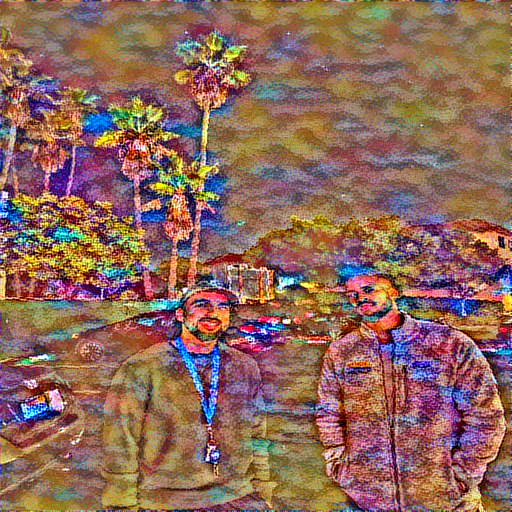

In [34]:
n=n.reshape((height,width, 3))
n= n[:,:, ::-1]
n[:, :,0] += 103.939
n[:, :, 1] += 116.779
n[:, :, 2] += 123.68
n = np.clip(n, 0, 255).astype('uint8')

Image.fromarray(n)